In [319]:
import numpy as np
import scipy as sp
from scipy import linalg as sp_linalg
import scipy.sparse
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from scipy.stats import kendalltau
%matplotlib inline

def lognormal_similarity_seed(rng, V):
    return rng.lognormal(mean=1, sigma=1, size=[V, V])

def gaussian_mixture_similarity_seed_factory(num_centers=10):
    def inner(rng, V):
        X, labels = make_blobs(n_samples=V,
                   n_features=num_centers,
                   centers=num_centers,
                   cluster_std=1.0,
                   shuffle=False,
                   random_state=rng)
        
        dist = euclidean_distances(X)
        
        with np.errstate(divide='ignore'):
            inv_dist = 1.0 / dist
        inv_dist[inv_dist == np.inf] = 0
        
        inv_dist /= inv_dist.mean()
        return inv_dist, X
    return inner

def generate_data(V=1000, power_law_alpha=1.0, similarity_seed_fun=lognormal_similarity_seed, seed=0):
    rng = np.random.RandomState(seed)
#     power_law_seed = rng.power(a=power_law_alpha, size=V)
    sims, X = similarity_seed_fun(rng, V)
    P_ij = np.triu(sims, k=1)
#     P_ij *= power_law_seed
    P_ij += P_ij.T #P_ij == P_ji
    P_ij /= P_ij.sum()

    p_i = P_ij.sum(axis=1)
    P_i = np.diag(p_i)
    P_i_inv = np.diag(1.0 / p_i)
    similarities = P_i_inv.dot(P_ij).dot(P_i_inv)

    with np.errstate(divide='ignore'):
        pmis = np.log(similarities)
    pmis[pmis == -np.inf] = 0

    assert np.allclose(similarities, similarities.T)
    assert np.allclose(similarities.dot(P_i).sum(axis=1), 1)
    assert np.allclose(P_ij, P_ij.T)
    assert np.allclose(pmis, pmis.T)
    assert np.allclose(P_i.sum(), 1)
    assert np.allclose(P_ij.sum(), 1)
    return P_ij, p_i, similarities, pmis, X

def sample_and_estimate(P_ij, sampling_factor=1.0, seed=0):
    rng = np.random.RandomState(seed)
    n = V**2 * sampling_factor

    emp_ij = rng.multinomial(n, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()

    emp_i = emp_ij.sum(axis=1)
    non_zeros = emp_i != 0
    emp_ij = emp_ij[non_zeros][:, non_zeros]
    emp_i = emp_i[non_zeros]

    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)

    with np.errstate(divide='ignore'):
        emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    return emp_pmi, non_zeros

def get_ranking(sims):
    neighbors = []
    for i in range(sims.shape[0]):
        neighbors.append(np.argsort(-sims[i]))
        
    return np.asarray(neighbors)

def recall(neighbors1, neighbors2):
    intersection = 0.0
    for i in range(neighbors1.shape[0]):
        intersection += len(set(neighbors1[i]) & set(neighbors2[i]))
        
    return intersection / (neighbors1.shape[0] * neighbors1.shape[1])

def tau(neighbors1, neighbors2):
    res = 0.0
    for i in range(neighbors1.shape[0]):
        tmp, _ = kendalltau(neighbors1[i], neighbors2[i])
        res += tmp
    return res / neighbors1.shape[0]

In [331]:
V = 100
seeded_rank = 10
similarity_seed_fun = gaussian_mixture_similarity_seed_factory(seeded_rank)
# rank = 5
num_neighbors = 10
# sampling_factor = 10.0

# P_ij, p_i, similarities, pmis, X = generate_data(V, power_law_alpha=alpha, 
#                                               similarity_seed_fun=similarity_seed_fun)

rng = np.random.RandomState(1)
isotropic_gaussian = rng.normal(size=[V, V])
Q, R = np.linalg.qr(isotropic_gaussian)
sigma = np.concatenate([np.ones(seeded_rank)*100, 1.0/np.arange(seeded_rank+1, V+1)])
pmis = Q.dot(np.diag(sigma)).dot(Q.T)

# for sampling_factor in [1, 10, 100]:
for rank in [3]:
#         emp_pmi, non_zeros = sample_and_estimate(P_ij, sampling_factor=sampling_factor)
    emp_pmi = pmis
    sparse_emp_pmi = scipy.sparse.csr_matrix(emp_pmi)

    true_pmis = pmis
    true_ranking = get_ranking(true_pmis)

    emp_u, emp_s, emp_v = scipy.sparse.linalg.svds(sparse_emp_pmi, k=rank)

    # Honest SVD reconstruction-based ranking with -inf on diagonal
    svd_sims = emp_u.dot(np.diag(emp_s)).dot(emp_v)
#     svd_sims = emp_u[:,0::2].dot(emp_u[:,0::2].T)
#     svd_sims = -euclidean_distances(emp_u)
    np.fill_diagonal(svd_sims, -np.inf)
    svd_ranking = get_ranking(svd_sims)

    # Cosine between rows of eigenvectors with -inf on diagonal
    normed_emp_u = normalize(emp_u[:, 0::2])
    cos_sims = normed_emp_u.dot(normed_emp_u.T)
    np.fill_diagonal(cos_sims, -np.inf)
    cos_ranking = get_ranking(cos_sims)

    svd_recall = recall(true_ranking[:, :num_neighbors], svd_ranking[:, :num_neighbors])
    cos_recall = recall(true_ranking[:, :num_neighbors], cos_ranking[:, :num_neighbors])

    svd_tau = tau(true_ranking, svd_ranking)
    cos_tau = tau(true_ranking, cos_ranking)
    print(f"Num: {sampling_factor}, R: {rank}, SVD Recall: {svd_recall}, Cos Recall: {cos_recall}, " + \
         f"SVD Tau: {svd_tau:.4f}, Cos Tau: {cos_tau:.4f}")

Num: 100, R: 3, SVD Recall: 0.318, Cos Recall: 0.172, SVD Tau: 0.0119, Cos Tau: 0.0032


In [311]:
emp_s

array([30.82354717, 49.49615901])

In [312]:
true_ranking[:3, :num_neighbors]

array([[48, 10,  6, 34, 41, 52,  9, 73, 59, 97],
       [41,  6,  4, 33,  9,  5, 35, 30, 16,  0],
       [25, 26, 47, 15, 13, 37, 45, 44,  5, 43]])

In [313]:
svd_ranking[:3, :num_neighbors]

array([[ 8, 19, 89, 22, 18, 10, 24, 59, 40, 34],
       [43, 23, 45, 44,  5, 15, 37, 32, 11,  2],
       [43, 23, 45, 44, 15,  5, 37, 32, 11, 26]])

In [314]:
cos_ranking[:3, :num_neighbors]

array([[49, 72, 71, 70, 69, 68, 67, 66, 65, 64],
       [ 0, 72, 71, 70, 69, 68, 67, 66, 65, 64],
       [ 0, 72, 71, 70, 69, 68, 67, 66, 65, 64]])

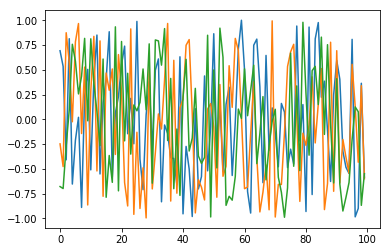

In [332]:
plt.plot(normalize(emp_u))

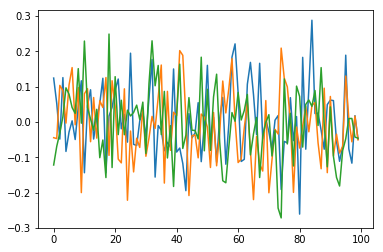

In [333]:
plt.plot(emp_u)

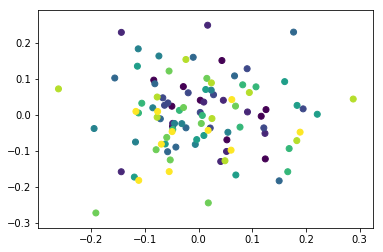

In [334]:
colours = []
for i in range(seeded_rank):
    colours += [i]*10

plt.scatter(emp_u[:,0], emp_u[:,-1], c=colours)

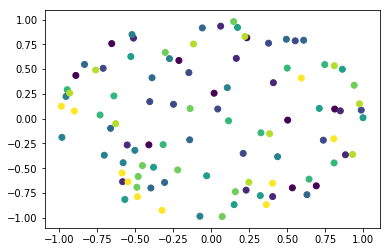

In [335]:
norm_emb_u = normalize(emp_u)
plt.scatter(norm_emb_u[:,0], norm_emb_u[:,-1], c=colours)

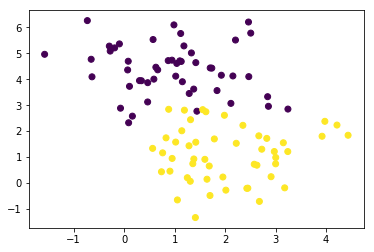

In [321]:
plt.scatter(X[:,0], X[:,-1], c=colours)

In [ ]:
# Num: 1, R: 3, SVD Recall: 0.40531, Cos Recall: 0.86512, SVD Tau: 0.2731, Cos Tau: 0.3123
# Num: 1, R: 5, SVD Recall: 0.74604, Cos Recall: 0.98997, SVD Tau: 0.2565, Cos Tau: 0.2531
# Num: 1, R: 10, SVD Recall: 0.99001, Cos Recall: 0.99125, SVD Tau: 0.2087, Cos Tau: 0.0895
# Num: 10, R: 3, SVD Recall: 0.53772, Cos Recall: 0.8651, SVD Tau: 0.2883, Cos Tau: 0.2885
# Num: 10, R: 5, SVD Recall: 0.97553, Cos Recall: 0.9902, SVD Tau: 0.3030, Cos Tau: 0.2297
# Num: 10, R: 10, SVD Recall: 0.99423, Cos Recall: 0.99297, SVD Tau: 0.3248, Cos Tau: 0.0903
# Num: 100, R: 3, SVD Recall: 0.54038, Cos Recall: 0.89412, SVD Tau: 0.2897, Cos Tau: 0.2877
# Num: 100, R: 5, SVD Recall: 0.98934, Cos Recall: 0.9908, SVD Tau: 0.3071, Cos Tau: 0.2288
# Num: 100, R: 10, SVD Recall: 0.9959, Cos Recall: 0.99319, SVD Tau: 0.3626, Cos Tau: 0.0965